## Pre-trained models for image classification

In [2]:
import torch
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt

### Download an image and `imagenet_classes.txt`

In [3]:
# sample file
!wget -q https://upload.wikimedia.org/wikipedia/commons/5/55/Hunting_Tiger_Ranthambore.jpg -O tiger.jpg

# the file contains all the classes in the imagenet dataset
# required to extract actual label from the NN
# the label is a number.
!wget -q https://github.com/nmilosev/pytorch-arm-builds/raw/master/imagenet_classes.txt

In [4]:
with open('imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

In [5]:
labels[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

### Initialize the model
- Don't forget to enable the `eval` mode.

In [6]:
net = models.shufflenet_v2_x1_0(pretrained=True) # this model coz it's fast.
net.eval()

/Users/saikamat/Local Documents/python_environments/pytorchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saikamat/Local Documents/python_environments/pytorchenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

### Normalization

Std. procedure for normalizing ImageNet images. 
- the method is available on PyTorch website
- it's imp. to apply same transformations same as that in the training dataset.

- So we resize the image, crop it, convert it into a tensor and normalizing it.

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Helper method
For inference which receives a `PIL` image and returns top 5 classes.

In [8]:
def infer(img):
    img_t = transform(img) 
    batch_t = torch.unsqueeze(img_t, 0) # convert into input of n/w compatible
    out = net(batch_t) # run image through model

    # code that extracts top 5 labels and percentages
    # top 5 coz otherwise results will be into the thousands
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    _, indices = torch.sort(out, descending=True)
    result = [(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]
    return result

### Load Image

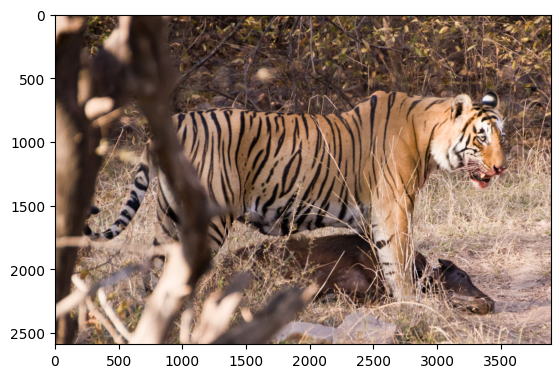

In [9]:
img = Image.open('tiger.jpg')
plt.imshow(img)

### Run the inference

In [10]:
infer(img)

[('tiger, Panthera tigris', 93.22502899169922),
 ('tiger cat', 2.323385238647461),
 ('bull mastiff', 0.776154637336731),
 ('boxer', 0.744747519493103),
 ('Staffordshire bullterrier, Staffordshire bull terrier',
  0.41503891348838806)]

### Exposing the Model



In [11]:
import sys, re, base64, io
from flask import jsonify
from flask import Flask, request

### Expose using Flask

- Run the ML code on a simple Flask server.

In [13]:
app = Flask(__name__)

@app.route('/infer', methods=['POST'])
def infer_image():
    image = str(request.form['image'])
    imgdata = base64.b64decode(image)
    image = Image.open(io.BytesIO(imgdata))
    return jsonify(infer(image))

app.run(port=8080)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8080
Press CTRL+C to quit
127.0.0.1 - - [09/Apr/2024 11:30:00] "POST /infer HTTP/1.1" 200 -


- Download a sample image, such as [GoldenRetriever.jpg](https://commons.wikimedia.org/wiki/Dog#/media/File:Vorderkoerpertiefstellung_THWZ.jpg)


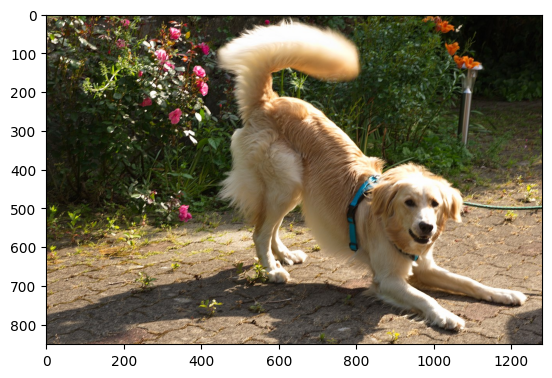

In [14]:
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Vorderkoerpertiefstellung_THWZ.jpg/1280px-Vorderkoerpertiefstellung_THWZ.jpg -O golden-retriever.jpg

flask_test_image = Image.open('golden-retriever.jpg')
plt.imshow(flask_test_image)

- Convert the image into Base64 using online tools like [Browserling.com](https://www.browserling.com/tools/image-to-base64)
- Use a REST API Client such as Postman
- The Request URL be `http://127.0.0.1:8080/infer`
- Create an HTTPS `POST` request, and in `body` >> `form-data` >> create a parameter called `image`
- Copy paste the `base64` into the `image`
- Hit `Send`

```json
[
    [
        "golden retriever",
        94.34349060058594
    ],
    [
        "Great Pyrenees",
        2.7543282508850098
    ],
    [
        "kuvasz",
        1.477584958076477
    ],
    [
        "Brittany spaniel",
        0.2545340061187744
    ],
    [
        "Shetland sheepdog, Shetland sheep dog, Shetland",
        0.2370687872171402
    ]
]
```